In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
train_file = pd.read_csv('Data/aspects_train.csv', '_')
test_file = pd.read_csv('Data/aspects_test.csv', '_')

train_file.head()

,text,FOOD#QUALITY,RESTAURANT#GENERAL,SERVICE#GENERAL,AMBIENCE#GENERAL,RESTAURANT#MISCELLANEOUS,FOOD#PRICES,RESTAURANT#PRICES,DRINKS#QUALITY,LOCATION#GENERAL,DRINKS#PRICES
0,Judging from previous posts this used to be a ...,0,1,0,0,0,0,0,0,0,0
1,"We, there were four of us, arrived at noon - t...",0,0,1,0,0,0,0,0,0,0
2,"They never brought us complimentary noodles, i...",0,0,1,0,0,0,0,0,0,0
3,The food was lousy - too sweet or too salty an...,1,0,0,0,0,0,0,0,0,0
4,"After all that, they complained to me about th...",0,0,1,0,0,0,0,0,0,0


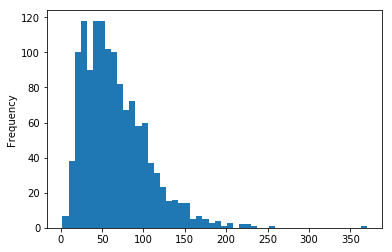

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
temp_train = pd.DataFrame()
temp_train['length'] = train_file['text'].apply(len)

# temp_train.head()
temp_train['length'].plot(bins=50,kind = 'hist')

In [4]:
temp_train.length.describe()

count    1315.000000
mean       65.936122
std        39.407046
min         2.000000
25%        36.000000
50%        58.000000
75%        88.000000
max       370.000000
Name: length, dtype: float64

In [5]:
from nltk import PunktSentenceTokenizer
from collections import Counter

class SentenceToVec() :
    def __init__(self, stop_words, vector_len=1000):
        self.vocab = []
        self.stop_words = stop_words
        self.vector_len = vector_len

        self.tokenizer = PunktSentenceTokenizer()
        
    def format_word(self, word):
        if word.isdigit():
            return "0"
        elif word in self.stop_words:
            return ""
        else:
            return word.strip()
    
    def tokenize(self, sentence):
        res_tokens = []
        tokens_temp = self.tokenizer.tokenize(sentence)
        for tokens in tokens_temp:
            tokens = nltk.word_tokenize(tokens)
            tokens = [self.format_word(t) for t in tokens]
            res_tokens += [t for t in tokens if t]
        return res_tokens
    
    def fit(self, X, y=None):
        self.vocab = []
        word_freq = Counter()
        for i in range(X.shape[0]):
            for w in self.tokenize(X[i]):
                if w not in self.stop_words:
                    word_freq[w] += 1
        
        for term, freq in word_freq.most_common():
            if len(self.vocab) < self.vector_len:
                self.vocab.append(term)
        return self
    
    def _vectorize(self, words):
        freq = dict(Counter(words))
        vector = []
        for v in self.vocab:
            vector.append(freq[v] if v in words else 0)
        return np.array(vector)
    
    def transform(self, X):
        _X = np.zeros((X.shape[0], len(self.vocab)))
        for i in range(X.shape[0]):
            _X[i] = self._vectorize(self.tokenize(X[i]))
        return _X

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path

stop_words = []

with Path.cwd().joinpath("stop_words_en.txt").open(encoding="utf-8") as f:
    stop_words = f.readlines()
    stop_words = [w.strip() for w in stop_words]

# count_vect = CountVectorizer()

# tf_vectorizer = TfidfVectorizer(stop_words='english')

sentenceToVec = SentenceToVec(stop_words=stop_words)

def process(df, isTrain=True):
    X = df['text']
    y = np.array(df.drop(['text'], axis=1))
    if isTrain:
        X = sentenceToVec.fit(X, y).transform(X)
    else:
        X = sentenceToVec.transform(X)
#     X = pd.DataFrame(X.todense(), columns=tf_vectorizer.get_feature_names())
#     X = pd.DataFrame(np.array(X))
#     print(X.shape)
    return X, y

In [7]:
train_X, train_y = process(train_file)
test_X, test_y = process(test_file, isTrain=False)

train_y
# test_X.head()
# test_X = np.array(test_X)
# test_X[0]

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

model = OneVsRestClassifier(LinearSVC(random_state=0))

hist = model.fit(train_X, train_y)

pred_y = model.predict(test_X)



# mean_absolute_error(test_y, pred_y)
# hist
# accuracy_score(test_y, pred_y)
print("Precision : " + str(precision_score(test_y, pred_y,average='micro')))
print("Recall : " + str(recall_score(test_y, pred_y,average='micro')))
print("F1 : " + str(f1_score(test_y, pred_y,average='micro')))



Precision : 0.36923076923076925
Recall : 0.2843601895734597
F1 : 0.321285140562249


In [9]:
k = 500
print(test_y[k])
print(pred_y[k])

[1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [10]:
cols = test_file.columns
cols
lines = []
for i in range(test_file.shape[0]):
    line = test_file.iloc[i]['text']
#     print(pred_y[i])
    line += '____'
    for j in range(len(test_y[i])):
        if test_y[i][j]==1:
            line += ('/' + cols[j + 1])
    line += '____'
    for j in range(len(pred_y[i])):
        if pred_y[i][j]==1:
            line += ('/' + cols[j + 1])
    line += '\n'
    print(line)
    lines.append(line)
#     break
with open('apect_predictions.csv', 'w') as f :
    f.write('text____actual____predictions\n')
    f.writelines(lines)

Love Al Di La____/RESTAURANT#GENERAL____/RESTAURANT#GENERAL

I recommend this place to everyone.____/RESTAURANT#GENERAL____/RESTAURANT#GENERAL

Great food.____/FOOD#QUALITY____/FOOD#QUALITY

One of my favorite places in Brooklyn.____/RESTAURANT#GENERAL____/RESTAURANT#GENERAL

The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing.____/FOOD#QUALITY____/FOOD#QUALITY

Overpriced and not tasty____/FOOD#QUALITY/FOOD#PRICES____/FOOD#QUALITY

The food here was mediocre at best.____/FOOD#QUALITY____/FOOD#QUALITY

It was totally overpriced- fish and chips was about $15....____/FOOD#PRICES____/FOOD#PRICES

There are so many other great places to go to eat and drink..... this place is not worth it...____/FOOD#PRICES____/RESTAURANT#GENERAL

Tasty Dog!____/FOOD#QUALITY____

An awesome organic dog, and a conscious eco friendly establishment.____/FOOD#QUALITY/RESTAURANT#MISCELLANEOUS____/SERVICE#GENERAL

One of the best hot dogs I have ever ea


Great Indian food____/FOOD#QUALITY____/FOOD#QUALITY

I lived on 50th st, and wanted Indian one day so decided to check this place out.____/FOOD#QUALITY____/RESTAURANT#GENERAL

Food was amazing - I love Indian food and eat it quite regularly, but I can say this is one of the best I've had.____/SERVICE#GENERAL____/FOOD#QUALITY

Very "normal Indian food", but done really well.____/FOOD#QUALITY/FOOD#PRICES____/FOOD#QUALITY

I have it a 4 instead of 5 because of the price (just chicken tikka masala - no bread of rice - is $25), which I would expect at a upscale Indian restaurant but this place doesn't have an upscale feel.____/SERVICE#GENERAL____/FOOD#QUALITY/FOOD#PRICES

Also, waiters try to push more food on you, like suggest things as if they are complimentary when they actually cost $.____/RESTAURANT#GENERAL____/SERVICE#GENERAL

I don't appreciate places or people that try to drive up the bill without the patron's knowledge so that was a huge turnoff (more than the price).____/FOOD#QUA